In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp latent_factor

# Latent Factors

> A latent factor, which in PyBATS is a random variable used as a predictor for regression. In this class, latent factors are described by a mean and a variance, but can also be integrated into a model through simulation, which is a more precise but slower process.

Latent factors are frequently used to model dependence among time series in a multivariate analysis. Several examples of doing this with a mean and variance are given in [Lavine, Cron, and West (2020)](https://arxiv.org/pdf/2007.04956.pdf), while examples using simulated values are given in [Berry and West (2019)](https://arxiv.org/pdf/1805.05232.pdf).

One example usage is for multiscale inference, where the time series have a hierarchical structure. In retail sales you may observe both the total sales in a store and the sales of an individual item. The sales in the store are more regular and predictable, so modeling them can produce smooth estimates of the day-of-week seasonality and the holiday effect at your store. These effects can be captured by a latent factor, and used as a predictor in a model of an individual item's sales, which are noisier and more unpredictable.

Let's say that the latent factor $\phi_t$ is created by model $\mathcal{M}_0$ of the time series $z_t$. The latent factor is used as a predictor of the series $y_t$ in model $\mathcal{M}_i$. The latent factor class describes $\phi_t$ through:
- A forecast mean and a variance, which is estimated *before* observing $z_t$, and is used to forecast $y_t$.
- An update mean and variance, which is estimated *after* observing $z_t$, and is used to update the state vector in $\mathcal{M}_i$ after observing $y_t$. Sometimes the latent factor is precisely known after observing $z_t$ (e.g. when the latent factor *is* $z_t$), and then the update variance is $0$.

Several common types of latent factors have been pre-defined in PyBATS:
1. `seas_weekly_lf`: The weekly seasonal effect latent factor.
2. `hol_lf`: The holiday effect latent factor
3. `Y_lf`: The observation latent factor. In this case, the forecast is simply the forecast mean and variance from $\mathcal{M}_0$, and the observed $z_t$ is used for updating.
4. `pois_coef_lf`, `bern_coef_lf`, and `dlm_coef_lf`: The coefficient (or state vector) latent factors for different types of DGLMs. These latent factors capture specified coefficients from $\mathcal{M}_0$.

Finally, the class `multi_latent_factor` concatenates multiple latent factors together when a model is using more than one latent factor as a predictor.

Simple examples of using latent factors are given below, and two more with a DCMM and a DBCM are provided in the [examples folder](https://github.com/lavinei/pybats_nbdev/tree/master/examples).

In [ ]:
#hide
#exporti
from functools import partial

import numpy as np
import pandas as pd
from collections.abc import Iterable
import copy
import pickle

from pybats_nbdev.seasonal import get_seasonal_effect_fxnl, forecast_weekly_seasonal_factor, forecast_path_weekly_seasonal_factor
from pybats_nbdev.dbcm import dbcm
from pybats_nbdev.dcmm import dcmm
from pybats_nbdev.forecast import forecast_aR, forecast_R_cov
from pybats_nbdev.dglm import dlm

In [ ]:
#export
class latent_factor:
    def __init__(self, mean={}, var={}, forecast_mean={}, forecast_var={}, forecast_cov={},
                 dates=[], forecast_dates=[],
                 gen_fxn = None, gen_forecast_fxn = None, forecast_path=False, p = None, k=None):
        
        self.forecast_mean = forecast_mean
        self.forecast_var = forecast_var
        self.forecast_cov = forecast_cov
        self.mean = mean
        self.var = var
        
        self.p = p
        self.k = k
        self.dates = dates
        self.forecast_dates = forecast_dates
        
        #if len(dates) != 0:
        #    self.start_date = np.min(dates)
        #    self.end_date = np.max(dates)
            
        #if len(forecast_dates) != 0:
        #    self.forecast_start_date = np.min(forecast_dates)
        #    self.forecast_end_date = np.max(forecast_dates)            

        if len(mean) != 0 and len(dates) != 0:
            if len(dates) != len(mean):
                print('Error: Dates should have the same length as the latent factor')
            #if isinstance(mean[0], Iterable):
            #    self.p = len(mean[0])
            #else:
            #    self.p = 1
            self.k = len(forecast_mean[dates[0]]) # forecast length
        self.gen_fxn = gen_fxn
        self.gen_forecast_fxn = gen_forecast_fxn

        self.forecast_path = forecast_path

    def get_lf(self, date):
        return self.mean[date], self.var[date]

    def get_lf_forecast(self, date):
        if self.forecast_path:
            return self.forecast_mean[date], self.forecast_var[date], self.forecast_cov[date]
        else:
            return self.forecast_mean[date], self.forecast_var[date]

    def generate_lf(self, date, **kwargs):
        m, v = self.gen_fxn(date, **kwargs)
        self.mean.update({date:m})
        self.var.update({date:v})
        if self.p is None:
            if type(m) == np.ndarray:
                self.p = len(m)
            else:
                self.p = 1
                
        self.dates.append(date)
        #self.start_date = np.min(self.dates)
        #self.end_date = np.max(self.dates)
        
        # m = pd.Series({date:m})
        # v = pd.Series({date:v})
        # self.mean = self.mean.append(m)
        # self.var = self.var.append(v)

    def generate_lf_forecast(self, date, **kwargs):
        if self.forecast_path:
            m, v, cov = self.gen_forecast_fxn(date, forecast_path=self.forecast_path, **kwargs)
            self.forecast_cov.update({date:cov})
        else:
            m, v = self.gen_forecast_fxn(date, forecast_path=self.forecast_path, **kwargs)

        self.forecast_mean.update({date:m})
        self.forecast_var.update({date:v})
        if self.k is None:
            self.k = len(m)
            
        self.forecast_dates.append(date)
        #self.forecast_start_date = np.min(self.forecast_dates)
        #self.forecast_end_date = np.max(self.forecast_dates)
        
        # m = pd.Series({date:m})
        # v = pd.Series({date:v})
        # self.forecast_mean = self.forecast_mean.append(m)
        # self.forecast_var = self.forecast_var.append(v)

    def copy(self):
        newlf = copy.deepcopy(self)

        return newlf

    def save(self, filename):
        file = open(filename, "wb")
        pickle.dump(self, file=file)
        
    @classmethod
    def load_latent_factor(filename):
        file = open(filename, 'rb')
        return pickle.load(file)

In [ ]:
#export
class multi_latent_factor(latent_factor):
    def __init__(self, latent_factors):
        """
        :param latent_factors: Tuple that contains only objects of class 'latent_factor'
        """
        self.n_lf = len(latent_factors)
        self.p = np.sum([lf.p for lf in latent_factors])
        self.k = np.min([lf.k for lf in latent_factors])
        self.latent_factors = latent_factors

        # initialize matrices that filled in when 'get_lf' and 'get_lf_forecast' are called
        self.mean = np.zeros(self.p)
        self.var = np.zeros([self.p, self.p])
        self.forecast_mean = [np.zeros(self.p) for k in range(self.k)]
        self.forecast_var = [np.zeros([self.p, self.p]) for k in range(self.k)]
        self.forecast_cov = [np.zeros([self.p, self.p, k]) for k in range(1, self.k)]

        # Set the start and end dates        
        start_date = np.max([np.min(lf.dates) for lf in latent_factors])
        end_date = np.min([np.max(lf.dates) for lf in latent_factors])
        self.dates = pd.date_range(start_date, end_date)

        # Set the start and end forecast dates
        forecast_start_date = np.max([np.min(lf.forecast_dates) for lf in latent_factors])
        forecast_end_date = np.min([np.max(lf.forecast_dates) for lf in latent_factors])
        self.forecast_dates = pd.date_range(forecast_start_date, forecast_end_date)

        if np.all([lf.forecast_path for lf in self.latent_factors]):
            self.forecast_path = True
        else:
            self.forecast_path = False

    def get_lf(self, date):
        idx = 0
        for lf in self.latent_factors:
            m, v = lf.get_lf(date)
            self.mean[idx:idx + lf.p] = m
            self.var[idx:idx + lf.p, idx:idx + lf.p] = v
            idx += lf.p

        return self.mean, self.var

    def get_lf_forecast(self, date):
        idx = 0
        if self.forecast_path:
            for lf in self.latent_factors:

                f_m, f_v, f_c = lf.get_lf_forecast(date)
                for k, [m, v] in enumerate(zip(f_m, f_v)):
                    self.forecast_mean[k][idx:idx + lf.p] = m
                    self.forecast_var[k][idx:idx + lf.p, idx:idx + lf.p] = v
                    if k > 0:
                        self.forecast_cov[k - 1][idx:idx + lf.p, idx:idx + lf.p, :] = f_c[k-1]
                idx += lf.p
            return self.forecast_mean, self.forecast_var, self.forecast_cov

        else:
            for lf in self.latent_factors:
                f_m, f_v = lf.get_lf_forecast(date)
                for k, [m, v] in enumerate(zip(f_m, f_v)):
                    self.forecast_mean[k][idx:idx + lf.p] = m
                    self.forecast_var[k][idx:idx + lf.p, idx:idx + lf.p] = v
                idx += lf.p
            return self.forecast_mean, self.forecast_var


    def copy(self):

        new_lfs = []
        for lf in self.latent_factors:

            new_lfs.append(lf.copy())

        return multi_latent_factor(new_lfs)

    def add_latent_factor(self, latent_factor):
        """
        :param latent_factor: A new latent factor to be added to the multi_latent_factor
        :return:
        """
        # Append the new latent_factor on
        self.latent_factors.append(latent_factor)

        self.n_lf = len(self.latent_factors)
        self.p = np.sum([lf.p for lf in self.latent_factors])
        self.k = np.min([lf.k for lf in self.latent_factors])

        # initialize matrices that filled in when 'get_lf' and 'get_lf_forecast' are called
        self.mean = np.zeros(self.p)
        self.var = np.zeros([self.p, self.p])
        self.forecast_mean = [np.zeros(self.p) for k in range(self.k)]
        self.forecast_var = [np.zeros([self.p, self.p]) for k in range(self.k)]
        self.forecast_cov = [np.zeros([self.p, self.p, k]) for k in range(1, self.k)]

        # Set the start and end dates
        start_date = np.max([np.min(lf.dates) for lf in latent_factors])
        end_date = np.min([np.max(lf.dates) for lf in latent_factors])
        self.dates = pd.date_range(start_date, end_date)

        # Set the start and end forecast dates
        forecast_start_date = np.max([np.min(lf.forecast_dates) for lf in latent_factors])
        forecast_end_date = np.min([np.max(lf.forecast_dates) for lf in latent_factors])
        self.forecast_dates = pd.date_range(forecast_start_date, forecast_end_date)

    def drop_latent_factor(self, idx):
        """
        :param idx: Index of the latent factor to drop
        :return:
        """
        # Append the new latent_factor on
        self.latent_factors.pop(idx)

        self.n_lf = len(self.latent_factors)
        self.p = np.sum([lf.p for lf in self.latent_factors])
        self.k = np.min([lf.k for lf in self.latent_factors])

        # initialize matrices that filled in when 'get_lf' and 'get_lf_forecast' are called
        self.mean = np.zeros(self.p)
        self.var = np.zeros([self.p, self.p])
        self.forecast_mean = [np.zeros(self.p) for k in range(self.k)]
        self.forecast_var = [np.zeros([self.p, self.p]) for k in range(self.k)]
        self.forecast_cov = [np.zeros([self.p, self.p, k]) for k in range(1, self.k)]

        # Set the start and end dates
        start_date = np.max([np.min(lf.dates) for lf in latent_factors])
        end_date = np.min([np.max(lf.dates) for lf in latent_factors])
        self.dates = pd.date_range(start_date, end_date)

        # Set the start and end forecast dates
        forecast_start_date = np.max([np.min(lf.forecast_dates) for lf in latent_factors])
        forecast_end_date = np.min([np.max(lf.forecast_dates) for lf in latent_factors])
        self.forecast_dates = pd.date_range(forecast_start_date, forecast_end_date)

    def save(self, filename):
        file = open(filename, "wb")
        pickle.dump(self, file=file)

The first latent factor example involves combining forecasts from different models. We have the forecast means and variances from 4 models that were used to predict quarterly US inflation from 1977 to 2014. One simple approach would be to use the 4 forecast means as predictors in a unified model. However, because we know the variance associated with each forecast, we can instead use a latent factor and account for the forecast uncertainty.

This example is inspired by [Bayesian Predictive Synthesis](https://arxiv.org/pdf/1601.07463.pdf), a sophisticated strategy for combining forecasts. This use of latent factors can be seen as an approximation to Bayesian Predictive Synthesis which allows for faster computation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pybats_nbdev.shared import load_us_inflation_forecasts
from pybats_nbdev.define_models import define_dglm
from pybats_nbdev.analysis import analysis
from pybats_nbdev.latent_factor import dlm_coef_lf
from pybats_nbdev.point_forecast import mean
from pybats_nbdev.loss_functions import MAPE
from pybats_nbdev.plot import plot_corr, plot_data_forecast

We start by loading in the data, which includes quarterly US inflation as well as the forecast means and variances from the 4 models.

In [ ]:
data = load_us_inflation_forecasts()
dates = data['Dates']

Next, we define the hyperaparameters and create the latent factor.

In this situation we're using the forecast mean and variance for updating as well, so the mean and forecast mean are the same, as are the variance and forecast variance.

In [ ]:
k = 1 #Forecast horizon: 1-quarter ahead
forecast_start = 50
forecast_end = 149
agents=[1,2,3,4]
nagents = len(agents)
Y = data['Inflation']

lf = latent_factor(
    mean = {d:m.astype('float64') for d, m in zip(dates, list(data['model_mean'].values))},
    var={d:np.diag(v).astype('float64') for d, v in zip(dates, list(data['model_var'].values))},
    forecast_mean={d:[m.astype('float64')] for d, m in zip(dates, list(data['model_mean'].values))},
    forecast_var={d:[np.diag(v).astype('float64')] for d,v in zip(dates, list(data['model_var'].values))},
    forecast_dates=dates,
    p = nagents,
    k = k)

In this example we're choosing to manually define a model *before* running an analysis. The reason is that we have prior information about the coefficients, and want to incorporate that information into the analysis. Specifically, we're giving each of the 4 models an equal starting weight by setting their coefficient means equal to $1/4$, and setting the intercept to $0$. The key parameters are:

- $a_0$, the prior mean of the coefficients
- $R_0$, the prior covariance matrix of the coefficients
- $s_0$, the prior observation variance in the normal dlm
- $n_0$, which is a prior weight, so the higher $n_0$ is the more confident the model is in $s_0$.

Setting `prior_length=0` means that we aren't using any of the observations in $Y$ to set our prior.

In [ ]:
kwargs = {'a0':np.concatenate([np.zeros(1), np.array([1/nagents]*nagents)]).reshape(-1,1),
          'R0':np.identity(nagents+1) / 0.99,
          's0':0.01,
          'n0':5*0.99,
          'deltrend': 0.99,
          'dellf':0.99,
          'delVar':0.99
          }

prior_length = 0

mod_prior = define_dglm(Y=Y, X=None,
                        family='normal',
                        seasPeriods=[], seasHarmComponents=[[]],
                        nlf=4,
                        **kwargs)

The analysis is run as normal, but with two extra arguments:
- The latent factor, `latent_factor=lf`
- The initialized model, `model_prior=mod_prior`.

In [ ]:
# Run updating + forecasting
samples, mod, coef = analysis(Y, X=None, family="normal",
                                         prior_length = prior_length, k = 1, ntrend=1, nsamps=5000,
                                         forecast_start=forecast_start, forecast_end=forecast_end,
                                         model_prior=mod_prior,
                                         latent_factor=lf,
                                         dates = dates,
                                         ret = ['forecast', 'model', 'new_latent_factors'],
                                         new_latent_factors= [dlm_coef_lf], **kwargs)


beginning forecasting


To evaluate the model, we can look at the forecast accuracy in terms of mean absolute percent error (MAPE):

In [ ]:
forecast = mean(samples)
np.round(MAPE(Y[forecast_start: forecast_end+1], forecast), 3)

12.669

And plot the $1-$quarter ahead forecasts. There is a clear 'lagged' pattern in the forecasts, in which the forecast is close to the previous observation. This is because the previous observation is a very important predictor in the 4 models that we are averaging together.

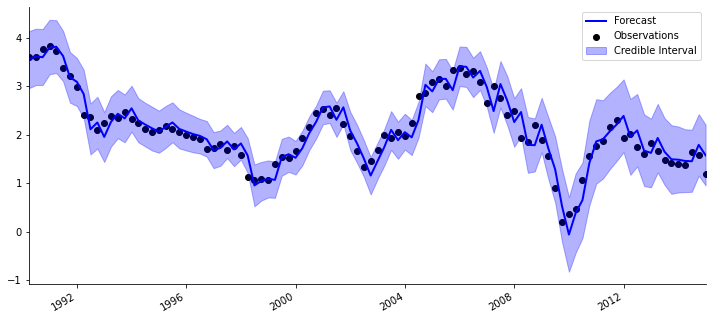

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plot_data_forecast(fig, ax,
                   Y[forecast_start:forecast_end+1],
                   forecast, samples,
                   dates[forecast_start:forecast_end+1],
                   linewidth = 2);

We can also look at the correlation matrix of our coefficients, telling us which ones are positively and negatively correlated. Typically, highly correlated variables have negatively correlated coefficients.

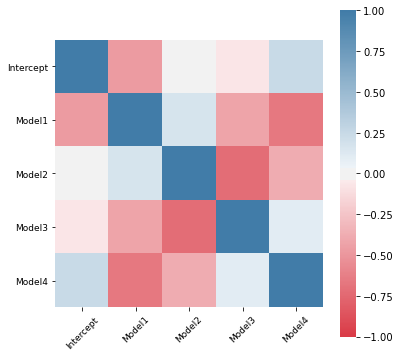

In [ ]:
D = np.sqrt(mod.R.diagonal()).reshape(-1,1)
corr = mod.R/D/D.T

fig, ax = plt.subplots(figsize=(6,6))
plot_corr(fig, ax, corr=corr, labels = ['Intercept', 'Model1', 'Model2', 'Model3', 'Model4']);

## Common Latent Factors

### Y (outcome) latent factor

In [ ]:
#export
def Y_fxn(date, mod, Y, **kwargs):
    return Y, 0

In [ ]:
#export
def Y_forecast_fxn(date, mod, X, k, nsamps, horizons, forecast_path = False, **kwargs):
    #
    # Y_mean = [f.mean() for f in forecast]

    if forecast_path:
        # if isinstance(mod, dlm):
        #     mean, var = mod.forecast_path(k=k, X=X, nsamps=nsamps, mean_var = True)
        #     Y_mean = [m for m in mean]
        #     Y_var = [v for v in var.diagonal()]
        #     Y_cov = [var[h,:h].reshape(1,1,h) for h in range(1, k)]
        # else:
            # print('error')
        forecast = mod.forecast_path(k=k, X=X, nsamps=nsamps)
        Y_mean = [m for m in forecast.mean(axis=0)]
        cov = np.cov(forecast, rowvar=False)
        Y_var = [v for v in forecast.var(axis=0)]
        Y_cov = [cov[h,:h].reshape(1, 1, -1) for h in range(1, k)]

        return Y_mean, Y_var, Y_cov

    else:
        forecast = list(map(lambda X, k: mod.forecast_marginal(k=k, X=X, nsamps=nsamps),
                            X,
                            horizons))
        Y_mean = list(map(lambda X, k: mod.forecast_marginal(k=k, X=X, mean_only=True),
                          X,
                          horizons))
        Y_var = [f.var() for f in forecast]
        return Y_mean, Y_var

In [ ]:
#export
Y_lf = latent_factor(gen_fxn = Y_fxn, gen_forecast_fxn = Y_forecast_fxn)

In [ ]:
#exporti
# This is a good idea, but note that it does not work with the set analysis fxns,
# This forecast must happen BEFORE updating, not after
def Y_update_via_forecast_fxn(date, mod, X, nsamps=200, **kwargs):
    mean = mod.forecast_marginal(k=1, X=X, mean_only=True)
    forecast = mod.forecast_marginal(k=1, X=X)
    return mean, forecast.var()

In [ ]:
#exporti
Y_forecast_lf = latent_factor(gen_fxn = Y_update_via_forecast_fxn, gen_forecast_fxn = Y_forecast_fxn)

### Weekly seasonal latent factor

In [ ]:
#export
def seas_weekly_fxn(date, mod, **kwargs):
    period = 7
    seas_idx = np.where(np.array(mod.seasPeriods) == 7)[0][0]
    today = date.dayofweek
    m, v = get_seasonal_effect_fxnl(mod.L[seas_idx], mod.m, mod.C, mod.iseas[seas_idx])
    weekly_seas_mean = np.zeros(period)
    weekly_seas_var = np.zeros([period, period])
    weekly_seas_mean[today] = m
    weekly_seas_var[today, today] = v

    return weekly_seas_mean, weekly_seas_var

In [ ]:
#export
def seas_weekly_forecast_fxn(date, mod, k, horizons, forecast_path=False, **kwargs):
    period = 7
    today = date.dayofweek

    if isinstance(mod, dlm):
        rt = mod.n / (mod.n-2)
    else:
        rt = 1

    if forecast_path:
        weekly_seas_mean, weekly_seas_var, weekly_seas_cov = forecast_path_weekly_seasonal_factor(mod, k, today, period)
        return weekly_seas_mean,  [rt * wsv for wsv in weekly_seas_var], [rt * wsc for wsc in weekly_seas_cov]
    else:

        # Place the weekly seasonal factor into the correct spot in a length 7 vector
        future_weekly_seas = list(map(lambda k: forecast_weekly_seasonal_factor(mod, k=k),
                                      horizons))
        weekly_seas_mean = [np.zeros(period) for i in range(k)]
        weekly_seas_var = [np.zeros([period, period]) for i in range(k)]
        for i in range(k):
            day = (today + i) % period
            weekly_seas_mean[i][day] = future_weekly_seas[i][0]
            weekly_seas_var[i][day, day] = future_weekly_seas[i][1]

        return weekly_seas_mean, [rt * wsv for wsv in weekly_seas_var]

In [ ]:
#export
seas_weekly_lf = latent_factor(gen_fxn = seas_weekly_fxn, gen_forecast_fxn=seas_weekly_forecast_fxn)

### Holiday latent factor

In [ ]:
#export
def hol_fxn(date, mod, X, **kwargs):
    is_hol = np.any(X[-mod.nhol:] != 0)
    mean = np.zeros(mod.nhol)
    var = np.zeros([mod.nhol, mod.nhol])
    if is_hol:
        idx = np.where(X[-mod.nhol:] != 0)[0][0]
        mean[idx] = X[-mod.nhol:] @ mod.m[mod.ihol]
        var[idx, idx] = X[-mod.nhol:] @ mod.C[np.ix_(mod.ihol, mod.ihol)] @ X[-mod.nhol:]

    return mean, var

In [ ]:
#export
def hol_forecast_fxn(date, mod, X, k, horizons, forecast_path=False, **kwargs):

    future_holiday_eff = list(map(lambda X, k: forecast_holiday_effect_dlm(mod, X, k),
                                  X[:, -mod.nhol:], horizons))
    hol_mean = [np.zeros(mod.nhol) for h in range(k)]
    hol_var = [np.zeros([mod.nhol, mod.nhol]) for h in range(k)]

    if forecast_path:
        hol_cov = [np.zeros([mod.nhol, mod.nhol, h]) for h in range(1, k)]
        nonzero_holidays = {}

        for h in range(k):
            if future_holiday_eff[h][0] != 0:
                idx = np.where(X[h, -mod.nhol:] != 0)[0][0]
                hol_mean[h][idx] = future_holiday_eff[h][0]
                hol_var[h][idx, idx] = future_holiday_eff[h][1]

                for j, idx_j in nonzero_holidays.items():
                    hol_cov[h-1][idx, idx_j, j] = hol_cov[h-1][idx_j, idx, j] = X[j, -mod.nhol:] @ forecast_R_cov(mod, j, h)[np.ix_(mod.ihol, mod.ihol)] @ X[h, -mod.nhol:].T

                nonzero_holidays.update({h:idx})

        return hol_mean, hol_var, hol_cov

    else:
        for h in range(k):
            if future_holiday_eff[h][0] != 0:
                idx = np.where(X[h, -mod.nhol:] != 0)[0][0]
                hol_mean[h][idx] = future_holiday_eff[h][0]
                hol_var[h][idx, idx] = future_holiday_eff[h][1]


        return hol_mean, hol_var

In [ ]:
#export
hol_lf = latent_factor(gen_fxn = hol_fxn, gen_forecast_fxn=hol_forecast_fxn)

This example demonstrates how to use the observation, seasonal, and holiday latent factors. The dataset contains simulated retail sales. `totaldata` are the daily total store sales, and `data` are the daily sales of a single item. We will fit a normal DLM to the log of total sales, and use it to learn the desired latent factors. This is a multiscale analysis because we're using the hierarchical relationship between the two time series.

First we load in the data:

In [ ]:
import matplotlib.pyplot as plt

from pybats_nbdev.plot import plot_data_forecast
from pybats_nbdev.latent_factor import Y_lf, seas_weekly_lf, hol_lf, multi_latent_factor
from pybats_nbdev.shared import load_dcmm_latent_factor_example
from pybats_nbdev.analysis import analysis
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats_nbdev.point_forecast import median

data = load_dcmm_latent_factor_example()
totaldata, data = data.values()
totaldata['Y'] = np.log(totaldata['Y'] + 1)

totaldata.head()

,Y,X
2014-06-01,5.613128,-0.133124
2014-06-02,5.602119,-0.070102
2014-06-03,5.831882,1.020901
2014-06-04,5.393628,2.219605
2014-06-05,5.267858,-0.970556


And then run a standard analysis for the normal DLM. We will send in the list of empty `new_latent_factors` that will be populated by model. We also need to specify `ret` so that latent factors are returned from this analysis.

Defining the forecast dates is important, even though we aren't trying to forecast the total sales. We need to forecast the latent factor so it can be used as a predictor in the individual item forecast.

In [ ]:
#Define hyper parameters
k = 14 # Number of days ahead that we will forecast
nsamps = 100
prior_length = 21
holidays=USFederalHolidayCalendar.rules

# Define forecast range for final year of data
T = len(totaldata)
forecast_end_date = totaldata.index[-k]
forecast_start_date = forecast_end_date - pd.DateOffset(days=365)

# Get multiscale signal (a latent factor) from higher level log-normal model
latent_factors = analysis(totaldata['Y'].values, totaldata['X'].values, k,
                         forecast_start_date, forecast_end_date,
                         family="normal", dates=totaldata.index,
                         seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                         holidays=holidays,
                         ret=['new_latent_factors'], new_latent_factors= [Y_lf, seas_weekly_lf, hol_lf],
                         prior_length=prior_length)

beginning forecasting


We now have a list of the 3 latent factors, which have been populated by the model. We can see their respective dimensions below:

In [ ]:
[lf.p for lf in latent_factors]

[1, 7, 10]

The first latent factor is `Y_lf`, which stores both the actual total sales and the forecast total sales. The second is `seas_weekly_lf`, which is a $7-$dimensional vector. Each day, the element for today is populated with the estimated seasonal effect, while the other $6$ values are set to $0$. Finally, we defined $10$ holidays. This latent factor is only populated on the holidays themselves, so it is mostly just $0$.

We can get the update mean for each latent factor at any given date:

In [ ]:
latent_factor_names = ['Total Sales', 'Weekly Seasonal', 'Holiday']
for lf, name in zip(latent_factors, latent_factor_names):
    print(name + ' mean:', lf.get_lf(forecast_start_date)[0].round(2))

Total Sales mean: 5.56
Weekly Seasonal mean: [ 0.    0.    0.    0.   -0.06  0.    0.  ]
Holiday mean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


And also the forecast mean for any date in the forecast window. Here are the $1:14$ day ahead forecasts for the total sales:

In [ ]:
print(latent_factor_names[0] + ' forecast mean: ', np.array(latent_factors[0].get_lf_forecast(forecast_start_date)[0]).round(2))

Total Sales forecast mean:  [5.42 5.65 5.76 5.55 5.39 5.36 5.35 5.43 5.64 5.8  5.22 5.38 5.36 5.34]


The $14-$day ahead forecast of the seasonal effects makes it clear how the latent factor works:

In [ ]:
print(latent_factor_names[1] + ' forecast mean: ')
print(np.array(latent_factors[1].get_lf_forecast(forecast_start_date)[0]).round(2))

Weekly Seasonal forecast mean: 
[[ 0.    0.    0.    0.   -0.07  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.16  0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.07  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.16  0.    0.    0.  ]]


The same output can be created for the holiday latent factor, but it will be all $0$'s except when there is a holiday in the next $14$ days.

Now let's combine these latent factors into a single `multi_latent_factor`, and put them to use in an analysis of the individual item sales:

In [ ]:
data.head()

,Y,X
2014-06-01,14.0,2.413448
2014-06-02,13.0,0.989871
2014-06-03,7.0,-0.489734
2014-06-04,34.0,-1.544868
2014-06-05,15.0,1.639670


First we create the multi latent factor:

In [ ]:
multi_lf = multi_latent_factor(latent_factors[:3])
print('Total dimension :', multi_lf.p)

Total dimension : 18


And then we run a standard analysis, while passing in the multi_lf as our latent factor. We're setting the discount factor on the latent factor component as `dellf=1`, which means no discounting. This is because the weekly seasonal pattern and holidays are $0$ so often. Another option would be to define `dellf` as an $18-$dimensional vector, with a separate discount factor for each element of the latent factor.

In [ ]:
# Update and forecast the model
rho = 0.2

mod, forecast_samples = analysis(data['Y'].values, data['X'].values, k,
                                 forecast_start_date, forecast_end_date,
                                 nsamps=nsamps, rho=rho,
                                 latent_factor = multi_lf,
                                 dates=data.index,
                                 dellf=1,
                                 prior_length = prior_length)

forecast = median(forecast_samples)

beginning forecasting


Looking at the forecasts, we can see a strong weekly seasonal pattern come through from the latent factors:

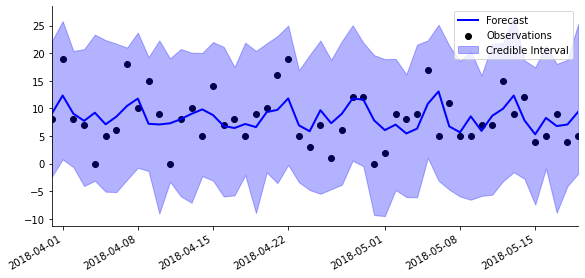

In [ ]:
# Plotting 1-step ahead forecasts
horizon = 1 
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax,
                        data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

### Model coefficient latent factors

In [ ]:
#export
def pois_coef_fxn(date, mod, idx = None, **kwargs):
    if type(mod) == dbcm:
        if idx is None:
            idx = np.arange(0, len(mod.dcmm.pois_mod.m))

        return mod.dcmm.pois_mod.m[idx].copy().reshape(-1), mod.dcmm.pois_mod.C[np.ix_(idx, idx)].copy()
    if type(mod) == dcmm:
        if idx is None:
            idx = np.arange(0, len(mod.pois_mod.m))

        return mod.pois_mod.m[idx].copy().reshape(-1), mod.pois_mod.C[np.ix_(idx, idx)].copy()

In [ ]:
#export
def pois_coef_forecast_fxn(date, mod, k, idx=None, **kwargs):
    if type(mod) == dbcm:
        if idx is None:
            idx = np.arange(0, len(mod.dcmm.pois_mod.m))

        pois_coef_mean = []
        pois_coef_var = []
        for j in range(1, k + 1):
            a, R = forecast_aR(mod.dcmm.pois_mod, j)
            pois_coef_mean.append(a[idx].copy().reshape(-1))
            pois_coef_var.append(R[np.ix_(idx, idx)].copy())
        return pois_coef_mean, pois_coef_var
    if type(mod) == dcmm:
        if idx is None:
            idx = np.arange(0, len(mod.pois_mod.m))

        pois_coef_mean = []
        pois_coef_var = []
        for j in range(1, k + 1):
            a, R = forecast_aR(mod.pois_mod, j)
            pois_coef_mean.append(a[idx].copy().reshape(-1))
            pois_coef_var.append(R[np.ix_(idx, idx)].copy())
        return pois_coef_mean, pois_coef_var

In [ ]:
#export
pois_coef_lf = latent_factor(gen_fxn = pois_coef_fxn, gen_forecast_fxn=pois_coef_forecast_fxn)

In [ ]:
#export
def bern_coef_fxn(date, mod, idx = None, **kwargs):
    if type(mod) == dbcm:
        if idx is None:
            idx = np.arange(0, len(mod.dcmm.bern_mod.m))

        return mod.dcmm.bern_mod.m[idx].copy().reshape(-1), mod.dcmm.bern_mod.C[np.ix_(idx, idx)].copy()
    if type(mod) == dcmm:
        if idx is None:
            idx = np.arange(0, len(mod.bern_mod.m))

        return mod.bern_mod.m[idx].copy().reshape(-1), mod.bern_mod.C[np.ix_(idx, idx)].copy()

In [ ]:
#export
def bern_coef_forecast_fxn(date, mod, k, idx = None, **kwargs):
    if type(mod) == dbcm:
        if idx is None:
            idx = np.arange(0, len(mod.dcmm.bern_mod.m))

        bern_coef_mean = []
        bern_coef_var = []
        for j in range(1, k + 1):
            a, R = forecast_aR(mod.dcmm.bern_mod, j)
            bern_coef_mean.append(a[idx].copy().reshape(-1))
            bern_coef_var.append(R[np.ix_(idx, idx)].copy())
        return bern_coef_mean, bern_coef_var

    if type(mod) == dcmm:
        if idx is None:
            idx = np.arange(0, len(mod.bern_mod.m))

        bern_coef_mean = []
        bern_coef_var = []
        for j in range(1, k + 1):
            a, R = forecast_aR(mod.dcmm.bern_mod, j)
            bern_coef_mean.append(a[idx].copy().reshape(-1))
            bern_coef_var.append(R[np.ix_(idx, idx)].copy())
        return bern_coef_mean, bern_coef_var

In [ ]:
#export
bern_coef_lf = latent_factor(gen_fxn=bern_coef_fxn, gen_forecast_fxn=bern_coef_forecast_fxn)

In [ ]:
#export
def dlm_coef_fxn(date, mod, idx = None, **kwargs):
    if idx is None:
        idx = np.arange(0, len(mod.m))

    return mod.m[idx].copy().reshape(-1), mod.C[np.ix_(idx, idx)].copy()

In [ ]:
#export
def dlm_coef_forecast_fxn(date, mod, k, idx=None, forecast_path=False, **kwargs):
    if idx is None:
        idx = np.arange(0, len(mod.m))

    p = len(idx)

    dlm_coef_mean = []
    dlm_coef_var = []
    if forecast_path:
        dlm_coef_cov = [np.zeros([p, p, h]) for h in range(1, k)]

    for j in range(1, k + 1):
        a, R = forecast_aR(mod, j)
        dlm_coef_mean.append(a[idx].copy().reshape(-1))
        dlm_coef_var.append(R[np.ix_(idx, idx)].copy())

        if forecast_path:
            if j > 1:
                for i in range(1, j):
                    dlm_coef_cov[j-2][:,:,i-1] = forecast_R_cov(mod, i, j)[np.ix_(idx, idx)]

    if forecast_path:
        return dlm_coef_mean, dlm_coef_var, dlm_coef_cov
    else:
        return dlm_coef_mean, dlm_coef_var

In [ ]:
#export
dlm_coef_lf = latent_factor(gen_fxn = dlm_coef_fxn, gen_forecast_fxn=dlm_coef_forecast_fxn)

The model coefficient latent factors are easy to understand. They store the state vector means and variances over time. If we simply wanted to plot the trajectory of a coefficient after an analysis, we don't need to use a latent factor. This is available in `analysis` by including `'model_coef'` in the list of items to return.

However, the latent factor can be useful for forecasting in two related models. For example, if there are two time series with very related predictors, then the coefficient from one model, multiplied by the predictor, may be a strong latent factor in another model.

In [ ]:
#exporti
def dlm_dof_fxn(date, mod, **kwargs):
    return mod.n, 0

In [ ]:
#exporti
def dlm_dof_forecast_fxn(date, mod, k, **kwargs):
    return [mod.n for x in range(k)], [0 for x in range(k)]

In [ ]:
#export
dlm_dof_lf = latent_factor(gen_fxn = dlm_dof_fxn, gen_forecast_fxn=dlm_dof_forecast_fxn)

### Helper Functions

In [ ]:
#exporti
def copy_fxn(date, latent_factor):
    s = latent_factor.get_lf(date)
    return copy.deepcopy(s[0]), copy.deepcopy(s[1])

In [ ]:
#exporti
def copy_forecast_fxn(date, latent_factor):
    means = []
    vars = []
    ms, vs = latent_factor.get_lf_forecast(date)
    for h in range(latent_factor.k):
        means.append(copy.deepcopy(ms[h]))
        vars.append(copy.deepcopy(vs[h]))
    return means, vars

In [ ]:
#export
def merge_fxn(date, latent_factors, **kwargs):
    if latent_factors[0].p == 1:
        m = np.array([float(lf.get_lf(date)[0]) for lf in latent_factors])
        v = np.array([float(lf.get_lf(date)[1]) for lf in latent_factors])
        p = 1 / v
        return np.sum(m * p) / np.sum(p), 1 / np.sum(p)
    else:
        ms = [lf.get_lf(date)[0] for lf in latent_factors]
        vs = [lf.get_lf(date)[1] for lf in latent_factors]
        ps = [np.linalg.inv(v) for v in vs]
        m = np.sum([p @ m.reshape(-1,1) for m, p in zip(ms, ps)], axis=0)
        v = np.linalg.inv(np.sum(ps, axis=0))
        mean = v @ m
        return mean.reshape(-1), v

In [ ]:
#export
def merge_forecast_fxn(date, latent_factors, **kwargs):
    k = np.min([lf.k for lf in latent_factors])
    lf_mean = []
    lf_var = []
    if latent_factors[0].p == 1:
        ms, vs = list(zip(*[lf.get_lf_forecast(date) for lf in latent_factors]))
        for h in range(k):
            m = np.array([float(m[h]) for m in ms])
            v = np.array([float(v[h]) for v in vs])
            p = 1 / v
            lf_mean.append(np.sum(m * p) / np.sum(p))
            lf_var.append(1 / np.sum(p))
        return lf_mean, lf_var
    else:
        ms, vs = list(zip(*[lf.get_lf_forecast(date) for lf in latent_factors]))
        ps = [[np.linalg.inv(var) for var in v] for v in vs]
        for h in range(k):
            m = np.sum([p[h] @ m[h].reshape(-1, 1) for m, p in zip(ms, ps)], axis=0)
            v = np.linalg.inv(np.sum([p[h] for p in ps], axis=0))
            mean = v @ m
            lf_mean.append(mean.reshape(-1))
            lf_var.append(v)
        return lf_mean, lf_var

In [ ]:
#export
def merge_latent_factors(latent_factors):

    # Set the start and end dates
    start_date = np.min([lf.start_date for lf in latent_factors])
    end_date = np.max([lf.end_date for lf in latent_factors])
    dates = pd.date_range(start_date, end_date)

    # Set the start and end forecast dates
    forecast_start_date = np.min([lf.forecast_start_date for lf in latent_factors])
    forecast_end_date = np.max([lf.forecast_end_date for lf in latent_factors])
    forecast_dates = pd.date_range(forecast_start_date, forecast_end_date)

    # Create a new latent factor
    merged_lf = latent_factor(gen_fxn = merge_fxn,
                              gen_forecast_fxn = merge_forecast_fxn)

    for date in dates:
        merged_lf.generate_lf(date, latent_factors=[lf for lf in latent_factors if lf.dates.isin([date]).any()])

    for date in forecast_dates:
        merged_lf.generate_lf_forecast(date, latent_factors=[lf for lf in latent_factors if lf.forecast_dates.isin([date]).any()])

    merged_lf.append_lf()
    merged_lf.append_lf_forecast()

    return merged_lf

`merge_latent_factors` is used to average together a set of latent factors. An example usage: There are a set of models, all with the same regression predictor. The coefficient latent factor is saved from an analysis. This function will produce a new latent factor which is the precision-weighted average effect from that coefficient.

In [ ]:
#export
def merge_lf_with_predictor(latent_factor, X, X_dates):

    newlf = latent_factor.copy()

    X = pd.DataFrame(X, index=X_dates)
    if latent_factor.p == 1:

        for date in newlf.dates:
            if X_dates.isin([date]).any():
                newlf.mean.loc[date] *= X.loc[date].values
                newlf.var.loc[date] *= (X.loc[date].values ** 2)
            else:
                newlf.mean.drop(date, inplace=True)
                newlf.var.drop(date, inplace=True)

        for date in newlf.forecast_dates:
            if X_dates.isin([date]).any():

                # m = newlf.forecast_mean.loc[date]
                # v = newlf.forecast_var.loc[date]
                for h in range(newlf.k):
                    newlf.forecast_mean.loc[date][h] *= X.loc[date + pd.DateOffset(days=h)].values
                    newlf.forecast_var.loc[date][h] *= (X.loc[date + pd.DateOffset(days=h)].values ** 2)
                # newlf.forecast_mean.loc[date] = m
                # newlf.forecast_var.loc[date] = v

                if newlf.forecast_path:
                    # c = newlf.forecast_cov.loc[date]
                    for h in range(1, newlf.k):
                        for j in range(h):
                            newlf.forecast_cov.loc[date][h-1][:,:,j] *= X.loc[date + pd.DateOffset(days=j)].values * X.loc[date + pd.DateOffset(days=h)].values
                    # newlf.forecast_cov.loc[date] = c
            else:
                newlf.forecast_mean.drop(date, inplace=True)
                newlf.forecast_var.drop(date, inplace=True)

                if newlf.forecast_path:
                    newlf.forecast_cov.drop(date, inplace=True)


    else:
        for date in newlf.dates:
            if X_dates.isin([date]).any():
                newlf.mean.loc[date] *= X.loc[date].values
                newlf.var.loc[date] *= X.loc[date].values.reshape(-1,1) @ X.loc[date].values.reshape(1,-1)
            else:
                newlf.mean.drop(date, inplace=True)
                newlf.var.drop(date, inplace=True)

        for date in newlf.forecast_dates:
            if X_dates.isin([date]).any():
                # m = newlf.forecast_mean.loc[date]
                # v = newlf.forecast_var.loc[date]
                for h in range(newlf.k):
                    newlf.forecast_mean.loc[date][h] *= X.loc[date + pd.DateOffset(days=h)].values
                    newlf.forecast_var.loc[date][h] *= X.loc[date + pd.DateOffset(days=h)].values.reshape(-1,1) @ X.loc[date + pd.DateOffset(days=h)].values.reshape(1,-1)
                # newlf.forecast_mean.loc[date] = m
                # newlf.forecast_var.loc[date] = v

                if newlf.forecast_path:
                    # c = newlf.forecast_cov.loc[date]
                    for h in range(1, newlf.k):
                        for j in range(h):
                            newlf.forecast_cov.loc[date][h-1][:,:,j] *= X.loc[date + pd.DateOffset(days=j)].values.reshape(-1,1) @ X.loc[date + pd.DateOffset(days=h)].values.reshape(1,-1)

                    # newlf.forecast_cov.loc[date] = c

            else:
                newlf.forecast_mean.drop(date, inplace=True)
                newlf.forecast_var.drop(date, inplace=True)

                if newlf.forecast_path:
                    newlf.forecast_cov.drop(date, inplace=True)

    return newlf

The function `merge_lf_with_predictor` multiplies a latent factor by a known predictor. This is useful in combination with the coefficient latent factors. To save a regression effect, the coefficient latent factor can store the dynamic coefficient from an analysis. Then, that latent factor can be multiplied by the predictor, to produce the full regression effect.

In [ ]:
#exporti
def pct_chg_from_lf_avg(latent_factor, window=10):

    def pct_chg_gen(date, ma, lf):
        m = 100 * (lf.mean.loc[date] - ma.loc[date]) / ma.loc[date]
        v = lf.var.loc[date] * (100 / ma.loc[date]) ** 2
        return m, v

    def pct_chg_gen_forecast(date, ma, k, lf):
        m = []
        v = []
        for h in range(lf.k):
            m.append(100 * ((lf.forecast_mean.loc[date][h] - ma.loc[date]) / ma.loc[date]))
            v.append(lf.forecast_var.loc[date][h] * (100 / ma.loc[date]) ** 2)

        return m, v


    ma = latent_factor.mean.rolling(window=window, min_periods=1).mean()
    ma = pd.Series(ma, index=latent_factor.dates)

    newlf = latent_factor(gen_fxn = partial(pct_chg_gen, lf=latent_factor, ma=ma), gen_forecast_fxn=partial(pct_chg_gen_forecast, lf=latent_factor, ma=ma, k=latent_factor.k))

    for date in latent_factor.dates:
        newlf.generate_lf(date)

    for date in latent_factor.forecast_dates:
        newlf.generate_lf_forecast(date)

    newlf.append_lf()
    newlf.append_lf_forecast()

    return newlf

In [ ]:
#exporti
def forecast_holiday_effect_dlm(mod, X, k):
    a, R = forecast_aR(mod, k)

    mean = X.T @ a[mod.ihol]
    var = (mod.n / (mod.n - 2)) * (X.T @ R[np.ix_(mod.ihol, mod.ihol)] @ X + mod.s)
    return mean, var

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_dglm.ipynb.
Converted 01_update.ipynb.
Converted 02_forecast.ipynb.
Converted 03_define_models.ipynb.
Converted 04_seasonal.ipynb.
Converted 05_analysis.ipynb.
Converted 06_conjugates.ipynb.
Converted 07_point_forecast.ipynb.
Converted 08_loss_functions.ipynb.
Converted 09_plot.ipynb.
Converted 10_shared.ipynb.
Converted 11_dcmm.ipynb.
Converted 12_dbcm.ipynb.
Converted 13_latent_factor.ipynb.
Converted 14_latent_factor_fxns.ipynb.
Converted index.ipynb.
